# R数据整理[tidyverse](https://github.com/tidyverse)
+ readr
+ dplyr
+ ggplot2
+ purrr
+ magrittr
+ tidyr 


## 一、几种基本函数

In [ ]:
# install.packages(c("nycflights13", "gapminder", "Lahman"))
library(tidyverse)
library(ggplot2)
mpg <- data(mpg)

+ 五个基本函数：可以解决主要的数据处理挑战
  + 第一个参数是data frame
  + 接下来的参数是描述如何操作，使用变量名不必带引号
  + 结果依然是data frame

In [2]:
# filter()    依靠值选择观测
# arrange()   对行进行排序
# select()    依靠列名选择变量
# mutate()    使用函数生成新的变量
# summarize() 描述
# 和group_by()配合使用,通过组改变函数操作的对象范围

+ `filter`按行选择观测值

In [3]:
filter(flights, month == 1, day == 1) -> jan1
dec <- filter(flights,month == 12, day == 25)


+ 比较运算符
  + =, >, >=, <, <=, !=, ==

+ 逻辑运算符
<img src="https://d33wubrfki0l68.cloudfront.net/01f4b6d39d2be8269740a3ad7946faa79f7243cf/8369a/diagrams/transform-logical.png" width="50%" height="50%" align="center" />

In [ ]:
df <- tibble(x = c(1,NA,3))
# filter支持多种逻辑判断删选:
filter(df,x>1)
filter(df,is.na(x) | x > 1)
filter(flights, !(arr_delay > 120 | dep_delay > 120))
filter(flights, arr_delay <= 120, dep_delay <= 120)

+ 缺失值 `NA`(Not Avaiables)
+ `is.na(x)`：判断是否是缺失值
+ `NA`会传染,接触就会被同化

In [5]:
NA > 5
10 == NA
NA/2
X <- NA
Y <- NA
X == Y


[1] NA

[1] NA

[1] NA

[1] NA

+ `arrange`排序

In [ ]:
arrange(flights, year, month, day) # 默认升序
arrange(flights, desc(dep_delay))  # 降序
df <- tibble(x = c(5, 2, NA))
arrange(df, x)                     # 缺失值永远被排在最后

+ `select`按列选择

In [ ]:
select(flights, year, month, day)
select(flights, year:day)           # 选中year与day之间的列
select(flights, -(year:day))        # 选中除了year与day之间的列


+ 还有多种条件语句可用
  + `starts_with("abc")`
  + `ends_with("xyz")`
  + `contains("ijk")`
  + `matches("(.)\\1")`: selects variables that match a regular expression. 
  + `num_range("x", 1:3)`: matches x1, x2 and x3.


In [ ]:
rename(flights, tail_num = tailnum)                # Select()可用于重命名变量，但它很少有用，因为它会删除所有未显式提到的变量。相反，使用rename()，这是select()的一个变体，它保留所有没有显式提到的变量;
select(flights, time_hour, air_time, everything()) # time_hour, air_time移动到开头;
select(flights, contains("TIME"))                  # 包含time的变量;

+ `mutate`增加变量

In [ ]:
flights_sml <- select(flights, 
  year:day, 
  ends_with("delay"), 
  distance, 
  air_time
)
mutate(flights_sml,
  gain = dep_delay - arr_delay,
  speed = distance / air_time * 60
)
mutate(flights_sml,
  gain = dep_delay - arr_delay,
  hours = air_time / 60,
  gain_per_hour = gain / hours
)
transmute(flights,               # 近保留增加的新变量
  gain = dep_delay - arr_delay, 
  hours = air_time / 60,
  gain_per_hour = gain / hours
)


+ 配合使用多种运算符
+ %/% (integer division) 正除
+ %% (remainder)         求余
+ x == y * (x %/% y) + (x %% y).

In [ ]:
transmute(flights,
  dep_time,
  hour = dep_time %/% 100,
  minute = dep_time %% 100
)


+ `summarize`分组总结
  + 直接使用没多大用处
  + 配合`group_by将会发挥强大功能

In [11]:
summarise(flights, delay = mean(dep_delay, na.rm = TRUE))


delay
<dbl>
12.63907


In [ ]:
by_day <- group_by(flights, year, month, day)
summarise(by_day, delay = mean(dep_delay, na.rm = TRUE))

  + 配合管道符

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



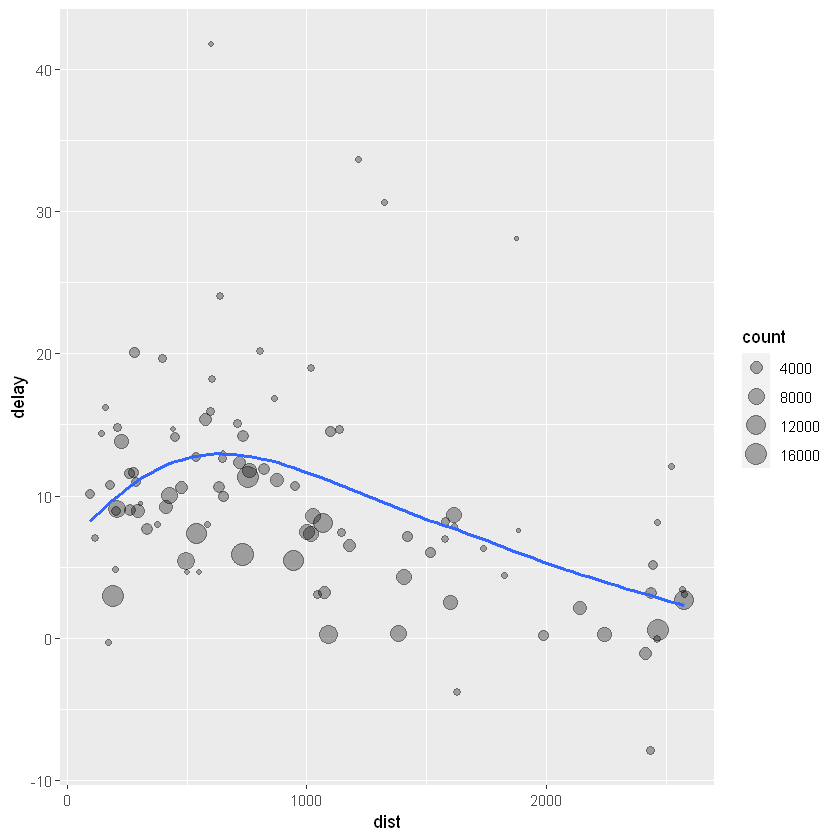

In [13]:
by_dest <- group_by(flights, dest)
delay <- summarise(by_dest,
  count = n(),                            # 描述的过程中生成的一些变量;
  dist = mean(distance, na.rm = TRUE),
  delay = mean(arr_delay, na.rm = TRUE)
) # 将这些结果赋值给一个新df,命名为delay,仅包含新生成的变量和分组的变量；

delay <- filter(delay, count > 20, dest != "HNL")

# It looks like delays increase with distance up to ~750 miles 
# and then decrease. Maybe as flights get longer there's more 
# ability to make up delays in the air?
ggplot(data = delay, mapping = aes(x = dist, y = delay)) +
  geom_point(aes(size = count), alpha = 1/3) +
  geom_smooth(se = FALSE)
#> `geom_smooth()` using method = 'loess' and formula 'y ~ x'

+ 上面的代码读起来有些费解,使用管道符,更简洁并且易理解

In [14]:
delays <- flights %>% 
  group_by(dest) %>% 
  summarise(
    count = n(),
    dist = mean(distance, na.rm = TRUE),
    delay = mean(arr_delay, na.rm = TRUE)
  ) %>% 
  filter(count > 20, dest != "HNL")


+ x `%>%` f(y) turns into f(x, y), 
+ x `%>%` f(y) `%>%` g(z) turns into g(f(x, y), z)

In [ ]:
# flights %>% group_by(year,month,day) %>% summarise(mean = mean(dep_delay))
# 有一个缺失值,结果全部是缺失值
flights %>% group_by(year,month,day) %>% summarise(mean = mean(dep_delay,na.rm = TRUE))

`summarise()` has grouped output by 'year', 'month'. You can override using the
`.groups` argument.


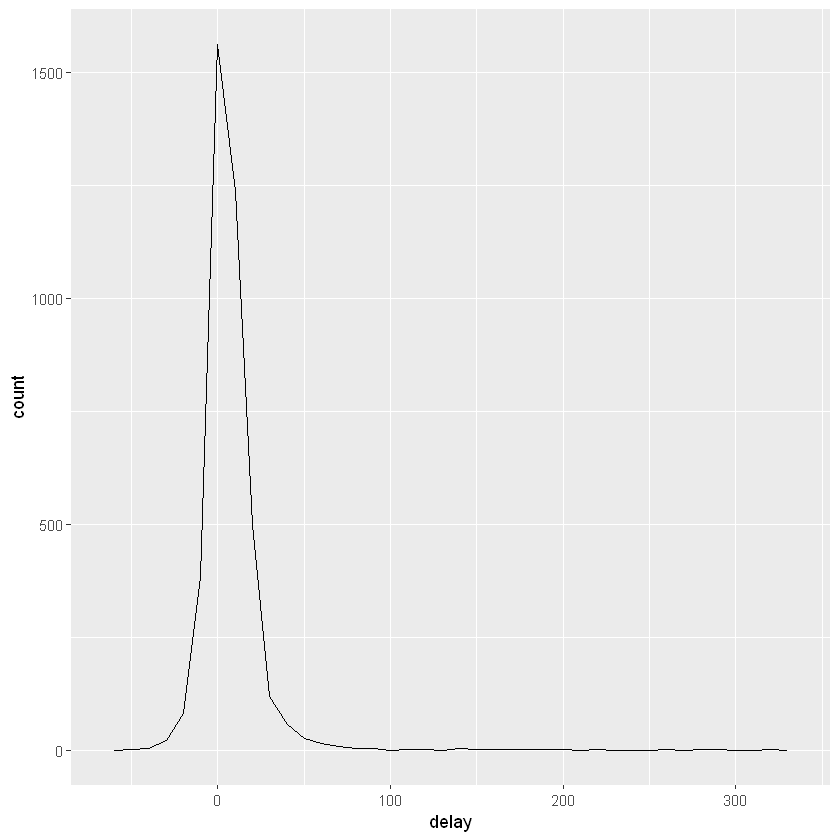

In [16]:
not_cancelled <- flights %>% 
  filter(!is.na(dep_delay), !is.na(arr_delay))

not_cancelled %>% 
  group_by(year, month, day) %>% 
  summarise(mean = mean(dep_delay))  -> group_year 


delays <- not_cancelled %>% 
  group_by(tailnum) %>% 
  summarise(
    delay = mean(arr_delay)
  )
ggplot(data = delays, mapping = aes(x = delay)) + 
  geom_freqpoly(binwidth = 10)


## 二、命令编程和函数式编程
+ 可以用更少的代码，更少的bug解决迭代问题

In [2]:
library(tidyverse)
df <- tibble(
  a = rnorm(10),
  b = rnorm(10),
  c = rnorm(10),
  d = rnorm(10)
)
df


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



a,b,c,d
<dbl>,<dbl>,<dbl>,<dbl>
0.59845259,0.24042315,-0.01506699,1.42382858
0.43292318,0.24179866,-2.56230682,-1.55659208
1.70479823,-0.97632247,0.67464091,0.39335033
-0.01777891,0.28230403,-0.54838911,1.79711574
0.79048960,1.17100742,0.10582818,-0.18221786
-0.21796354,0.78092101,-2.03585067,-0.87295347
-0.58618025,1.06858076,1.34521285,0.37098229
-0.22016637,-0.58660607,-0.62424124,1.66790583
1.51289360,-0.90701675,-0.08893197,-0.49260547


+ 首先一列列计算各列的中位数

In [3]:
median(df$a)
median(df$b)
median(df$c)
median(df$d)

[1] 0.5156879

[1] 0.2411109

[1] -0.05199948

[1] 0.2289828

+ 纯手动，麻烦，借用循环：

In [4]:
output <- vector("double",ncol(df))
for (i in seq_along(df)) {
    output[[i]] <- median(df[[i]])
}
output

[1]  0.51568789  0.24111090 -0.05199948  0.22898284

+ 看一下`1:length(y)`和`seq_along(y)`的区别

In [26]:
y <- vector("double",0)
print(seq_along(y))

integer(0)


In [27]:
print(1:length(y))

[1] 1 0


+ 观察以下循环

In [28]:
out <- ""
for (x in letters) {
  out <- stringr::str_c(out, x)
}
out

x <- sample(100)
sd <- 0
for (i in seq_along(x)) {
  sd <- sd + (x[i] - mean(x)) ^ 2
}
sd
sd <- sqrt(sd / (length(x) - 1))
sd

x <- runif(10)
x
out <- vector("numeric", length(x))
out
out[1] <- x[1]
for (i in 2:length(x)) {
  out[i] <- out[i - 1] + x[i]
}

rescale01 <- function(x) {
  rng <- range(x, na.rm = TRUE)    # range取出最大值和最小值
  (x - rng[1]) / (rng[2] - rng[1])
}
df$a <- rescale01(df$a)
a <- 1


+ 两种循环方式
  + 遍历对象中的元素:有两种
    + 对元素遍历 :`for (x in df)`
    + 对变量名遍历:`for (name in names(df))`
  + 整数遍历:`for (i in seq_along(df))`

In [5]:
means <- c(0, 1, 2)

output <- double()
for (i in seq_along(means)) {
  n <- sample(100, 1)
  output <- c(output, rnorm(n, means[[i]]))
}
str(output)


 num [1:137] 1.271 -0.997 0.695 -1.002 0.595 ...


+ 上面是随机生成三列个数不等的数据框,循环没有效率,因为每次迭代中R都要从之前的迭代中赋值所有数据,多要多出几倍的时间;
+ 换个思路:将结果保存在一个列表中,然后循环完成后再将其合并为一个单一的数据框:

In [ ]:
out <- vector("list", length(means))
for (i in seq_along(means)) {
  n <- sample(100, 1)
  out[[i]] <- rnorm(n, means[[i]])
}
str(out)
out[1]
out[[1]]
out[[1]][1]


## 三、函数式编程

In [15]:
# 首先生成一个数据框
df <- tibble(
  a = rnorm(10),
  b = rnorm(10),
  c = rnorm(10),
  d = rnorm(10)
)
# 使用循环计算各列均值
output <- vector("double", length(df))
for (i in seq_along(df)) {
    output[[i]]  <- mean(df[[i]])
}
output
# 可以将上面的过程函数化，来设计一个专门计算数据框各列均值的函数：
# 函数参数是数据框，返回结果是各列的均值：
col_mean <- function(df) {
  output <- vector("double", length(df))
  for (i in seq_along(df)) {
    output[[i]]  <- mean(df[[i]])
  }
output
}
col_mean(df)
# 如果计算中位数、标准差等，则直接修改对应的函数即可，但是要复制修改多个函数；

[1]  0.07753887 -0.20979977  0.08645358 -0.02119470

[1]  0.07753887 -0.20979977  0.08645358 -0.02119470

+ 此时可以使用函数式编程

In [8]:
col_summary <- function(df, fun) {
  out <- vector("double", length(df))
  for (i in seq_along(df)) {
    out[i] <- fun(df[[i]])
  }
  out
}
col_summary(df, mean)
col_summary(df, median) # 将函数作为参数输入；


[1] -0.10807607 -0.06590937 -0.10920091  0.30950536

[1] -0.5259546 -0.1534275  0.4290026  0.5271705

## 四、The Map functions
+ map() makes a list.
+ map_lgl() makes a logical vector.
+ map_int() makes an integer vector.
+ map_dbl() makes a double vector.
+ map_chr() makes a character vector.
+ 每一个函数将向量作为输入，函数作用于每一个元素，然后返回一个新向量，和输入一样长度；

In [16]:
map_dbl(df, mean)
map_dbl(df, median)
map_dbl(df, sd)

a           b           c           d 
 0.07753887 -0.20979977  0.08645358 -0.02119470

a           b           c           d 
 0.53595403  0.16121149  0.23922864 -0.06009379

a         b         c         d 
1.1797796 1.1463308 0.8935980 0.9933482

+ 此时我么不需要关注循环以及怎么存储结果等，而只需要关注里面的操作符，使用管道符的时候更加明显；

In [17]:
df %>% map_dbl(mean)
df %>% map_dbl(median)

a           b           c           d 
 0.07753887 -0.20979977  0.08645358 -0.02119470

a           b           c           d 
 0.53595403  0.16121149  0.23922864 -0.06009379

+ 第二个参数是要应用的函数，它可以是公式、字符向量或整数向量；

In [28]:
map_dbl(df, mean)
map_dbl(df, mean, trim = 0.5)

a           b           c           d 
 0.07753887 -0.20979977  0.08645358 -0.02119470

a           b           c           d 
 0.53595403  0.16121149  0.23922864 -0.06009379

In [29]:
z <- list(x = 1:3, y = 4:5)
map_int(z, length)

x y 
3 2

+ 快捷方式

In [31]:
models <- mtcars %>%
  split(.$cyl) %>%
  map(function(df) lm(mpg ~ wt, data = df)) #都是用同一个式子进行回归， 

In [33]:
models <- mtcars %>% 
  split(.$cyl) %>% 
  map(~lm(mpg ~ wt, data = .)) # 这里用. 代表传入参数，用~后输入表达式

In [38]:
models %>% map(summary) %>% map_dbl(~.$r.squared)
models %>% map(summary) %>% map_dbl("r.squared")

4         6         8 
0.5086326 0.4645102 0.4229655

4         6         8 
0.5086326 0.4645102 0.4229655

+ 使用位置参数

In [39]:
x <- list(list(1, 2, 3), list(4, 5, 6), list(7, 8, 9))
x %>% map_dbl(2)

[1] 2 5 8